
This notebook provided an end to end example of calibrating and applying a random forest to estimate LAI from Landsat 8 OLI using an approximation of the MODIS MCD15 algorithm.
The calibration is based on a limited sample size to make it fast for this demo.


The notebook relies on sklearn to calibrate the random forest, geemap to format and upload this into Google Earth Engine, and ee to access the Earth Engine API to process imagery.


In [316]:
import ee
import geemap
from geemap import ml
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor


Before you begin you need to save the calibration data files on a local drive here

https://drive.google.com/drive/folders/1r4lXElk6yht6rez1K7_XAW50Oj38zZ-6?usp=sharing

and update the file path  in box below.  

In [320]:
bucketName = '/home/richard_fernandes/modislandsat/Calibrationv5/NorthAmerica/'
fileSuffix = 'calv7'

You also have to provide a path to a GEE directory where you have write permissions and a file root name for each of the output classifiers.  They will get a suffix for each MCD15 biome number.

In [321]:
geeFilePath = 'projects/ccmeo-ag-000008/assets/modisLandsat' 
geeClassifierRootName = '/treesModisLandsatNAv5'


You will need a GEE account to save uploaded random forest classifiers and to apply them.

In [200]:
ee.Authenticate()

Enter verification code:  4/1ARtbsJrCXRTAGkkBHWcd5EjnfREVuBDMGpDrkv1tfsjERJod9TRLvipYUo0



Successfully saved authorization token.


In [201]:
ee.Initialize() 

These are functions for preparing the calibration dataset.  They are specific to MCD15 and Landsat 8 data sampled by CCRS algorithms.

In [317]:
# function to parse a file of samples generated from CCRS code to a forma for use in random forest calibration
def parseSamples(bucketName,fileSuffix):

    # specify sampled files for calibation
    # rows in each file match
    file_name = ['LUTinputLC0XB36', 'LUTinputLC0XB45','LUTinputMOD09' ,'LUTinputLC0XLat', \
                 'LUTinputLC0XLon','LUToutputLC0X','YearLC0X','MonthLC0X', \
                 'DayLC0X','PathLC0X','RowLC0X']
    
    # read files in to dictionary 
    dataset = {}
    for name in file_name:
        name_dataset = bucketName+name+fileSuffix
        if ( 'gs:' not in bucketName ) :
            with open(f'{name_dataset}', 'rb') as fp1:
                objs = []
                while 1:
                    try:
                        objs.append(pickle.load(fp1))
                    except EOFError:
                        break
                dataset[name] = [item for sublist in objs for item in sublist]
        else: 
                    dataset[name] = (pd.read_pickle(name_dataset))

                
    # parse the LUTs into Pandas tables
    LUT_Lai = np.double(np.floor(np.mod(np.array(dataset['LUToutputLC0X']),1e2)/1e0))
    LUT_LaiStdDev = np.double(np.floor(np.floor(np.mod(np.array(dataset['LUToutputLC0X']),1e4)/1e2)))
    LUT_Fpar = np.double(np.floor(np.mod(np.array(dataset['LUToutputLC0X']),1e6))/1e4)
    LUT_FparStdDev = np.double(np.floor(np.floor(np.mod(np.array(dataset['LUToutputLC0X']),1e8)/1e6)))
    LUT_satFlag = np.uint64(np.floor(np.mod(np.array(dataset['LUToutputLC0X']),1e11))/1e8)
    LUT_snowFlag = np.uint64(np.floor(np.floor(np.mod(np.array(dataset['LUToutputLC0X']),1e14)/1e11)))
    LUT_LC_Type3 = np.uint64(np.floor(np.floor(np.mod(np.array(dataset['LUToutputLC0X']),1e16)/1e14)))
    LUT_SR_B3 = np.double(np.floor(np.floor(np.mod(np.array(dataset['LUTinputLC0XB36']),1e3)/1)))
    LUT_SR_B4 = np.double(np.floor(np.floor(np.mod(np.array(dataset['LUTinputLC0XB45']),1e3)/1)))
    LUT_SR_B5 = np.double(np.floor(np.floor(np.mod(np.array(dataset['LUTinputLC0XB45']),1e6)/1e3)))
    LUT_SR_B6 = np.double(np.floor(np.floor(np.mod(np.array(dataset['LUTinputLC0XB36']),1e6)/1e3)))
    LUT_VIEW_ZENITH = np.double(np.floor(np.floor(np.mod(np.array(dataset['LUTinputLC0XB45']),1e8)/1e6)))
    LUT_VIEW_AZIMUTH = np.double(np.floor(np.floor(np.mod(np.array(dataset['LUTinputLC0XB45']),1e11)/1e8)))
    LUT_SUN_ELEVATION = np.double(np.floor(np.floor(np.mod(np.array(dataset['LUTinputLC0XB45']),1e13)/1e11)))
    LUT_SUN_AZIMUTH = np.double(np.floor(np.floor(np.mod(np.array(dataset['LUTinputLC0XB45']),1e16)/1e13)))
    LUT_MOD09_red = np.double(np.floor(np.floor(np.mod(np.array(dataset['LUTinputMOD09']),1e4)/1)))
    LUT_MOD09_NIR = np.double(np.floor(np.floor(np.mod(np.array(dataset['LUTinputMOD09']),1e8)/1e4)))
    LUT_MSUN_ZENITH = np.uint64(np.floor(np.floor(np.mod(np.array(dataset['LUTinputMOD09']),1e10)/1e8)))
    LUT_MSUN_AZIMUTH = np.uint64(np.floor(np.floor(np.mod(np.array(dataset['LUTinputMOD09']),1e13)/1e10)))
    LUT_MVIEW_ZENITH = np.uint64(np.floor(np.floor(np.mod(np.array(dataset['LUTinputMOD09']),1e15)/1e13)))
    LUT_MVIEW_AZIMUTH = np.uint64(np.floor(np.floor(np.mod(np.array(dataset['LUTinputMOD09']),1e18)/1e15)))
    
    # make pandas frame of all coded inputs
    return pd.DataFrame( {'year':dataset['YearLC0X'], 'month': dataset['MonthLC0X'], 'day': dataset['DayLC0X'], 'path':dataset['PathLC0X'], 'row':dataset['RowLC0X'],\
                          'Lat':dataset['LUTinputLC0XLat'], 'Lon':dataset['LUTinputLC0XLon'], 'input36': dataset['LUTinputLC0XB36'],'input45':dataset['LUTinputLC0XB45'], \
                           'inputMOD09': dataset['LUTinputMOD09'], 'redMODIS': LUT_MOD09_red,'NIRMODIS': LUT_MOD09_NIR,\
                          'SR_B3':LUT_SR_B3 * 10, 'SR_B4':LUT_SR_B4 * 10, 'SR_B5': LUT_SR_B5 * 10, 'SR_B6': LUT_SR_B6 * 10,   \
                          'VZA':LUT_VIEW_ZENITH, 'VAA': LUT_VIEW_AZIMUTH, 'SZA':LUT_SUN_ELEVATION, 'SAA': LUT_SUN_AZIMUTH, \
                          'M_sensor_zenith':LUT_MVIEW_ZENITH, 'M_sensor_azimuth': LUT_MVIEW_AZIMUTH, 'M_sun_zenith':LUT_MSUN_ZENITH, 'M_sun_azimuth': LUT_MSUN_AZIMUTH, \
                          'LC_type3': LUT_LC_Type3, 'output': dataset['LUToutputLC0X'],'LAI': LUT_Lai, 'stdLAI': LUT_LaiStdDev, 'FAPAR': LUT_Fpar, 'stdFAPAR': LUT_FparStdDev,\
                          'LUT_satFlag': LUT_satFlag,'LUT_snowFlag': LUT_snowFlag,'LC_type3': LUT_LC_Type3}) \
               .sort_values('input36')        


In [318]:
# trims a dataframe of outliers of the conditional distribution of y given x using fixed sample sizesd
def trimDFNumSample(df,x,y,percentiles,bins,numsamples):
    # sort DF by the x value to speed up subsetting
    dropList = []
    sortList = df.sort_values(by=x).reset_index()
    for i in bins:
        # find location of value nearest to current bin
        binIndex = sortList.loc[sortList[x]>i].index
        if not binIndex.empty:
            lenList = len(sortList)
            Sample = sortList.iloc[(np.maximum((binIndex[0]-100),0)):(np.minimum((binIndex[0]+100), lenList))]
            if not Sample.empty:
                dropList.append(Sample.loc[Sample[y]<np.percentile(Sample[y],percentiles[0])]['index'].values.tolist()) 
                dropList.append(Sample.loc[Sample[y]>np.percentile(Sample[y],percentiles[1])]['index'].values.tolist())
    return df.drop(sum(dropList,[]))

In [319]:
# trim calibration data based on comparing Landsat and MODIS equivalents
# note we oversample the MODIS axis as we trim
# this takes some time

def trimDF(df):

    # thresholds 
    df = df[(df.redMODIS < 100) & (df.SR_B4 > 0) & (df.SR_B3 > 0 ) & (df.SR_B5 > 0 )  & (df.SR_B6 > 0 )& (df.SR_B4 < np.quantile(df.SR_B4,0.99)) & (df.SR_B3 < np.quantile(df.SR_B3,0.99)) \
             & (df.SR_B5 < np.quantile(df.SR_B5,0.99)) & (df.SR_B6 < np.quantile(df.SR_B6,0.99)) & (df.VZA<20)]
 

    # trim based on red
    df = trimDFNumSample(df,'redMODIS','SR_B4',[10,90],np.arange(100,1000.0,10),10000)

    #trim based on nir
    df = trimDFNumSample(df,'NIRMODIS','SR_B5',[10,90],np.arange(100,1000.0,10),10000)
  
    return df

Code blocks below show the sampled data locations and then calibrate random forests that are uploaded to your GEE accout.

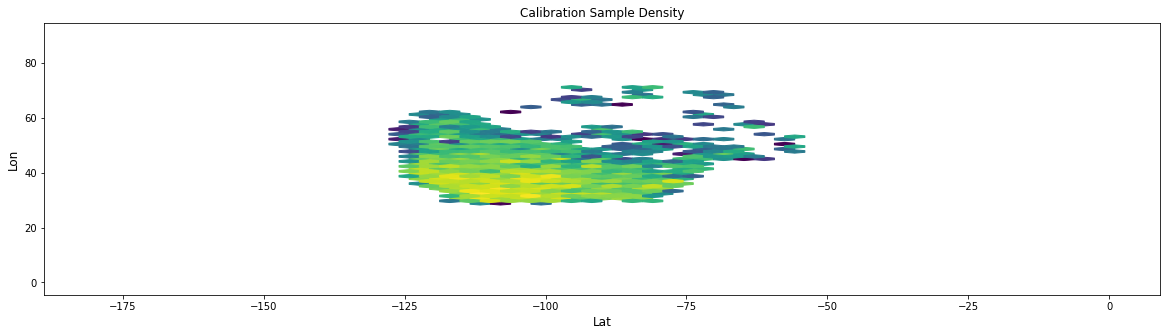

In [196]:
# read calibration data and display locations 
# does not seem to read entire file from Goolge, so now using local drive
dfALL= trimDF(parseSamples(bucketName,fileSuffix))
fig,ax = plt.subplots(1,1)
fig.set_figheight(5)
fig.set_figwidth(20)
im=ax.hexbin(dfALL['Lon'],dfALL['Lat'], gridsize=(50,50), extent=(-180,0,0,90),bins='log')
ax.set_xlabel('Lat',size = 12)
ax.set_ylabel('Lon',size = 12)
ax.set_title('Calibration Sample Density')
plt.show()

This loop makes a random forest regression for each biome type using sklearn on local machine and then uploads as a feature collection to GEE.
Check your GEE assets to make sure it is completed.

You later have to cast the feature collection as a classifier to use it.  


In [301]:
# calibrate and export random forests to GEE as feature collections
# to parse these into classifiers see https://geemap.org/notebooks/46_local_rf_training/#convert-a-sklearn-classifier-object-to-a-list-of-strings
# you can also export as local binary files and not feature collections, faster but then this is not as transparent as usig GEE objects

# specify input features and random forestd response
rawfeatures = ['SR_B3', 'SR_B4', 'SR_B5', 'SR_B6','SAA','SZA']
response= ['LAI']
forests = {}

# loop through all biome types indxed using LC_type3
for biome in dfALL['LC_type3'].unique():
    
    #select only calibration samples for current biome
    df = dfALL.loc[dfALL['LC_type3']==biome]
    print(biome,df.shape[0])
    forests[str(biome)] = RandomForestRegressor(n_estimators=2,min_samples_leaf=10,bootstrap=True,random_state=0,verbose=0).fit(df[rawfeatures], np.array(df[response]).ravel())


     # create a ee classifier to use with ee objects from the trees
    trees = ml.rf_to_strings(estimator=forests[str(biome)], feature_names=rawfeatures,output_mode='REGRESSION') 
    
    # kick off an export process so it will be saved to the ee asset
    ml.export_trees_to_fc(trees, geeFilePath + geeClassifierRootName + str(biome))
    


4 70482
2 59954
1 177401
7 17030
10 306
6 15529
3 10663
9 9168
5 1054
8 182


In [ ]:
This code applies the random forest for biome type 4  to a Landsat 8 OLI image.  

To do so it casts a selected  GEE classifier for that biome type and applies it to the Landsat 8 OLI surface reflectance image
AFTER we have added the required geometry bands.

In practice you need to add a biome type layer to the OLI image correspindig to LC_type3 number and then map this process over each LC_type3 using 
the appropriate classifier.


In [ ]:
#  add solar zenith and azimuth bands to a landsat 8 image 
def addL08Geometry(image) :
    
    geometryBands = ee.ImageCollection("LANDSAT/LC08/C02/T1_TOA").filterMetadata('system:index','equals',image.get('system:index')) .first() 
    
    return image.addBands(geometryBands.select(['SZA','SAA']))

In [305]:
# read the exported tree feature collection
classifier1  =  ml.fc_to_classifier(ee.FeatureCollection( geeFilePath  + geeClassifierRootName + 'Biome4'))
classified = addL08Geometry(ee.ImageCollection("LANDSAT/LC08/C02/T1_L2").first()).select(rawfeatures).classify(classifier1)
print(classified.getInfo())